# Finding Exoplanets with Python

Transit method: The transit method is a photometric method that aims to indirectly detect the presence of one or more exoplanets in orbit around a star.<br>
<img src="https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2003/06/planet_transit/9798645-3-eng-GB/Planet_transit_pillars.jpg" width="600px" height="auto">

In [2]:
# Import dependencies
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import numpy as np

Now we will download the files of the subject that we wish to study

In [3]:
pixelFile = search_targetpixelfile("KIC 6922244", author="Kepler", cadence="long", quarter=4).download()

* 6922244 is the star we will be looking at(KIC6922244), also known as Kepler-8
* Q
uarter stands for a time frame. each year has 4 quarters, this means that we are looking at data from the 1st year of the kepler mission. 

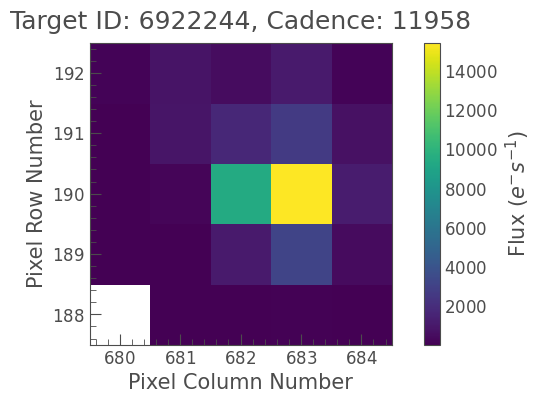

In [4]:
pixelFile.plot(frame=42)

Looking at these graphs is pretty fun, but overall useless on their own, so we'll need to convert these frames into a graph(<b>AKA</b> a light curve)

Aperture masks make the image better to analyse. 

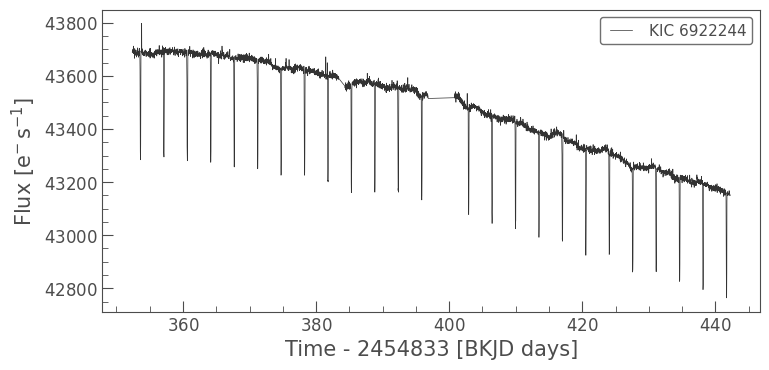

In [5]:
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()

From this light curve, we can see periodic dips in the luminosity of Kepler-8. From this we can ascertain that <b>something</b> is orbiting the star. For some reason, the overall luminosity of the star seems to be decreasing. This can be due to multiple factors: 
* Maybe the telescope was moving away from the star during observation(this data is recorded from the [Kepler space telescope](https://en.wikipedia.org/wiki/Kepler_space_telescope))
* Maybe a dust cloud? 
* Astrophage? :P

However, the overall luminosity dropping makes it harder for us to analyse the star, therefore we need to make use of the below command. 

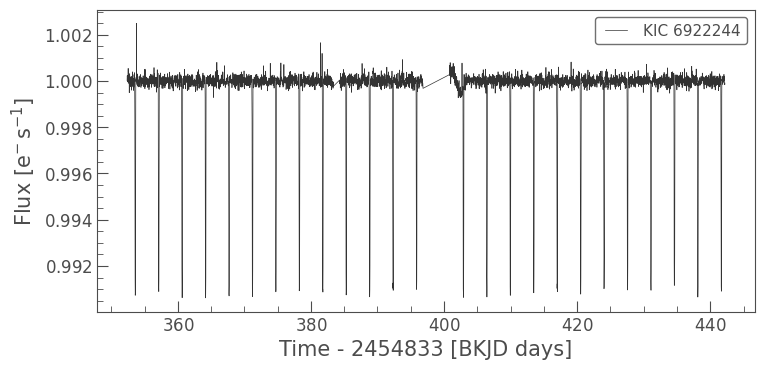

In [6]:
flat_lc = lc.flatten()
flat_lc.plot()

We now phase fold the light curve to verify that the period and the transit time correspond to the transit signal. Essentially the result is the frequency spikes are folded on each other if the period is correct. 

But how do we ascertain the correct period? We make use of a statistical analysis called a [periodogram](https://en.wikipedia.org/wiki/Periodogram). This essentially shows all the repititive patterns in your graph, and gives you a most likely candidate. 

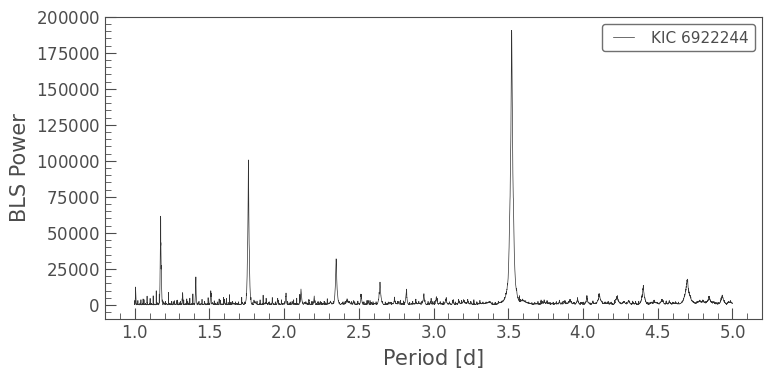

In [7]:
period = np.linspace(1,5,10000)
# BLS = Box Least Squares
bls = lc.to_periodogram(method="bls", period=period, frequency_factor=500)
bls.plot()

We'll now take the period with the highest peak, and that is what we will use for phase folding the light curve. 

In [8]:
highest_peak = bls.period_at_max_power
print(f"Period of highest peak in periodogram: {highest_peak}")
highest_peak_transit_time = bls.transit_time_at_max_power
print(f"Transit time of highest peak in periodogram: {highest_peak_transit_time}")
highest_peak_duration = bls.duration_at_max_power
print(f"Duration of highest peak in periodogram: {highest_peak_duration}")

Period of highest peak in periodogram: 3.522652265226523 d
Transit time of highest peak in periodogram: 353.60132485035285
Duration of highest peak in periodogram: 0.1 d


We'll use the highest peak period to make a folded light curve. 

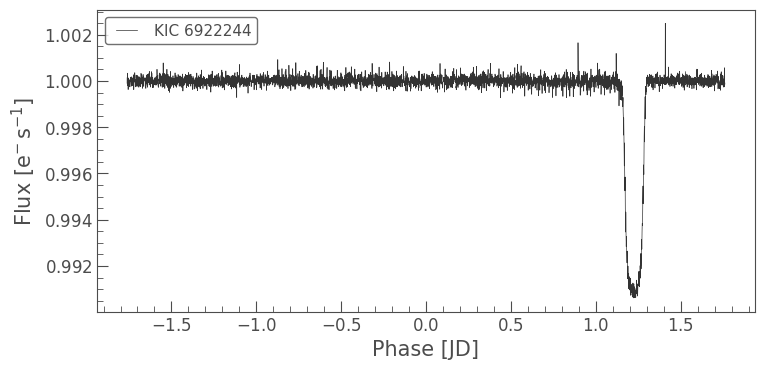

In [9]:
folded_lc = flat_lc.fold(period=highest_peak)
folded_lc.plot()

We can make an alternate light curve that is a scatter plot. 

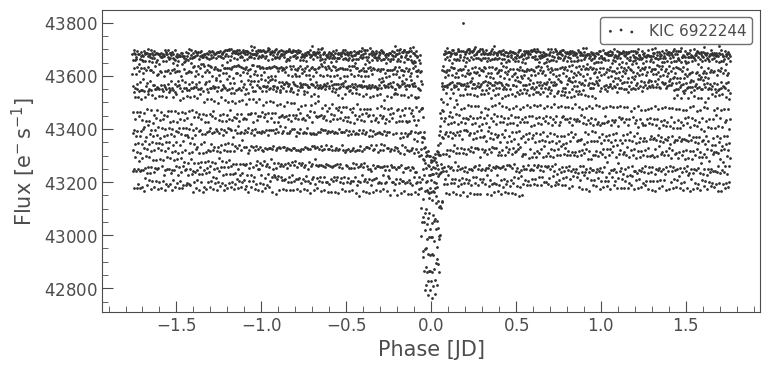

In [10]:
scatter_lc = lc.fold(period=highest_peak, epoch_time=highest_peak_transit_time).scatter()